In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pyomo.core.base.objective import minimize
from pyomo.environ import ConcreteModel, AbstractModel, Var, Objective, Constraint, ConstraintList, SolverFactory
from pyomo.environ import maximize, Binary, RangeSet, Set, NonNegativeReals, Reals

from utils import *
from utils_3d import *

# Interger Linear Programming for Protein Folding
In this notebook, we show different integer linear programming (ILP) models for solving semplified versions of the protein folding problem.  
Predicting the three-dimensional structure of a protein, given its amino acid sequence, is a critical task in biochemistry and computational biology since it can help to better understand some diseases and the development of new drugs.
Since the search space is huge brute force is not an option and atomic-level modeling is computationally prohibitive, so many simplified models and approaches have been developed during the years. One of particular interest is the HP model.

## HP model
The HP model relies on three semplifications:
1. divide the 20 amino acids in two 2 groups:
    - Hydrophobic (non-polar) indicated with H
    - Hydrophilic (polar) indicated with P
Hence, our protein sequence becomes a binary string
2. Proteins in a cell are surrounded by water so the H amino acids are likely to be forced in the interior of the folded protein, while the P stay on the exterior.
3. Stability of the folding is maximized by the number of bonds between hydrophobic amino acids (H-H bonds)

In the first section of this notebook we aim to predict the 2-D structure of a protein by considering it as a binary string (according to the HP model) embed on a two-dimensional grid. The code and results shown take inspiration from the paper [Protein folding on lattices : An integer programming approach](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2154543).  


Whereas in the second section we try to predict the 3-D structure of a protein embed on three-dimensional cubic lattice by using the ILP model described in the paper [An integer programming model for protein structure prediction using the 3D-HP side chain model](https://www.sciencedirect.com/science/article/pii/S0166218X15003078). 

In [8]:
protein_sequence = "HHPHPHPHHP" # "HPPHHHPHPHPPHHPHHH"
protein_binary_sequence = get_binary_string(protein_sequence)

print("Protein sequence:", protein_sequence)
print("Protein binary sequence:", protein_binary_sequence)
n = len(protein_sequence)
print("Protein length:", n)

print("Offset: ", calculate_offset(protein_binary_sequence))

Protein sequence: HHPHPHPHHP
Protein binary sequence: 1101010110
Protein length: 10
Offset:  2


## Protein folding on lattices : An integer programming approach
In this section we took inspiration from the paper [Protein folding on lattices : An integer programming approach](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2154543) and tried to reproduce their results.  
The aim is to predict 2D - HP protein folding on a rectangular lattice and formulate the model as an ILP problem.  

### Formulation
- $ s_k $ : amino acid that can be either hydrophobic (H) or hydrophilic (P)
- $ s_t $ and $ s_{t+1} $ are adjacent on the chain, with $ 1 \leq t \leq n-1 $
- $ H $ : set of hydrophobic amino acids
- Consider a $ (2n-1) * (2n-1) $ grid
- $ (i,j) $ : lattice point or vertex in the grid, $ 1 \leq i,j \leq 2n-1 $
- $ (i,j) $ and $ (u,v) $ are neighbours if one of the following is true:
    - $ u=i \qquad\text{and}\qquad v=j+1 \qquad\text{or}\qquad v=j-1 $
    - $ v=j \qquad\text{and}\qquad u=i+1 \qquad\text{or}\qquad u=i-1 $
- $ N_{ij} $ : set of adjacent vertices to vertex $ (i,j) $
- *Connected neighbours* : pair of amino acids that occure in successive positions in the chain
- *Topological neighbours* : pair of non-successive amino acids that are adjacent in the embedding  

- Define grid graph $ G = (V,E) $ where every edge is of the form $ ((i,j),(u,v)) $ where $ (u,v) \in N_{ij} $ with $ 1 \leq i,j \leq 2n-1 $
- First amino acid $ s_1 $ is placed at the center of the grid $ (n,n) $

### Goal
Place amino acids $ s_k $ at vertices $ (i,j) $ such that the following are satisfied
- each amino acid is placed at exactly one vertex
- each vertex has at most one amino acid
- amino acids adjacent on the chain must be placed at adjacent vertices  

And maximize the number of amino acids H that are topologically adjacent.

### Decision Variables
$$ x_{ij}^{k} =
\begin{cases}
      1 & \text{if $ s_k $ is placed on $ (i,j) $}\\
      0 & \text{otherwise}
    \end{cases}   
$$
$$ y_{ij}^{uv} =
\begin{cases}
      1 & \text{if $ s_{a},s_{b} \in H $ are placed on $ (i,j) $ and $ (u,v) $ s.t. $ (u,v) \in N_{ij} $}\\
      0 & \text{otherwise}
    \end{cases}   
$$

### Objective function
$$ max \sum_{((i,j),(u,v)) \in E} { y_{ij}^{uv} } $$

### Constraints
1. $ s_{1} $ is placed on $ (n,n) $
$$ x_{nn}^1 = 1 $$
2. Each vertex has at most one amino acid
$$ \sum_{k=1}^{n} {x_{ij}^{k}} \leq 1 \qquad \forall (i,j) \qquad 1 \leq i,j \leq 2n-1 $$ 
3. Each amino acid is placed at exactly one vertex
$$ \sum_{i=1}^{2n-1} {\sum_{j=1}^{2n-1} {x_{ij}^{k}}} = 1 \qquad \forall k \qquad 1 \leq k \leq n $$ 
4. If amino acid $ k $ is placed at $ (i,j) $ then $ k+1 $ is placed at a vertex $ (u,v) \in N_{ij} $
$$ x_{ij}^{k} \leq \sum_{(u,v) \in N_{ij}} { x_{uv}^{k+1} } \qquad \forall (i,j) \qquad 1 \leq i,j \leq 2n-1 \qquad \forall k \qquad 1 \leq k \leq n-1 $$
5. 6 If $ y_{ij}^{uv} = 1 $ only if two H amino acids are placed at neighbours vertices
$$ y_{ij}^{uv} \leq \sum_{k \in H} { x_{ij}^{k} } \qquad \forall ((i,j),(u,v)) $$ 
$$ y_{ij}^{uv} \leq \sum_{k \in H} { x_{uv}^{k} } \qquad \forall ((i,j),(u,v)) $$ 
7. $ x_{ij}^{k} $ is binary {0, 1}  
8. $ y_{ij}^{uv} $ is binary {0, 1}

### Additional constraints
Instead of just restricting the positions of neighbours amino acid $ s_k $ and $ s_{k+1} $, let's restrict the positions of $ s_k $ and $ s_{k+t} $ ($ s_{k-t} $) at distance $ t $  
The distance between two vertices is defined as $ d_{ij}^{uv} = |u-i| + |v-j| $  
The additional constraints are the following:  
$$ x_{ij}^{k} \leq \sum_{(u,v) : d_{ij}^{uv} \leq t} { x_{uv}^{k+t} } \qquad \forall (i,j) \qquad 1 \leq i,j \leq 2n-1 \qquad \forall k \qquad 1 \leq k \leq n-t $$  
$$ x_{ij}^{k} \leq \sum_{(u,v) : d_{ij}^{uv} \leq t} { x_{uv}^{k-t} } \qquad \forall (i,j) \qquad 1 \leq i,j \leq 2n-1 \qquad \forall k \qquad t+1 \leq k \leq n $$  
As stated in the paper the usefulness of these constraints still have to be explored.  
We added a boolean argument *additional_constr* that allows you to decide whether to include those additional constraints or not.  
In the experiments performed, no particular improvements have been noted in the optimal solutions found and adding those constraints slows down the algorithm.

In [6]:
def ILP_graph_formulation(binary_seq, grid_size, additional_constr, formulation=""):
    model = ConcreteModel()

    ###################
    #   VARIABLES     #
    ###################

    n = len(binary_seq) # sequence length
    G = build_graph(binary_seq, grid_size=grid_size) # graph
    print("Number of edges:", G.number_of_edges())

    # Set of indices
    model.K = RangeSet(0, n - 1)    # set of indexes in sequence 
    model.K1 = RangeSet(0, n - 2)
    model.I = RangeSet(0, grid_size - 1) 
    model.H = Set(initialize=get_hydrophobic_set(binary_seq))   # set of indexes in sequence where value is 1 (hydrophobic)

    # Decision Variables
    model.x = Var(model.K, model.I, model.I, within=Binary)
    model.y = Var(model.I, model.I, model.I, model.I, within=Binary)
    print("Dim x:", len(model.x))
    print("Dim y:", len(model.y))


    ###################
    #   CONSTRAINTS   #
    ###################

    model.constraints = ConstraintList()

    if formulation != "alternative":
        # the first amino acid is placed on the center of the grid (n,n)
        model.constraints.add(expr = ( model.x[0, n, n] == 1 ) )
    # in the alternative formulation we'll see later we don't have this constraint

    # each vertex has at most one amino acid
    for i in model.I:
        for j in model.I:
            model.constraints.add(expr = ( sum( model.x[k, i, j] for k in model.K ) <= 1 ) )
        
    # each amino acid is placed at exactly one vertex
    for k in model.K:
        model.constraints.add(expr = ( sum( model.x[k, i, j] for i in model.I for j in model.I ) == 1 ) )

    # if amino acid k is placed at (i, j) then amino acid k+1 is placed at a vertex (u, v) adjacent
    # to vertex (i, j)
    for k in model.K1:
        for i in model.I:
            for j in model.I:
                try:
                    model.constraints.add(expr = ( model.x[k, i, j] <= sum( model.x[k+1, u, v] for (u, v) in G[(i,j)] ) ) )
                except:
                    # if node is not in edges
                    pass
    

    # we want y[i, j ,u, v]=1 only if an H amino acid is placed at (i,j) and another amino acid H is placed at a neighboring vertex
    for ((i, j), (u, v)) in G.edges():
        model.constraints.add(expr = ( model.y[i, j, u, v] <= sum( model.x[k, i, j] for k in model.H ) ) )
        model.constraints.add(expr = ( model.y[i, j, u, v] <= sum( model.x[k, u, v] for k in model.H ) ) )

    # Additional Constraints
    # ensure that if k is placed on (i, j) then k+t (or k-t) must be placed on a vertex with distance <= t from (i, j)
    if additional_constr:
        for t in model.K:
            for i in model.I:
                for j in model.I:
                    for k in range(0, n - t):
                        model.constraints.add(expr = ( model.x[k, i, j] <= sum( model.x[k+t, u, v] for (u, v) in get_neighbours(G, i, j, t) ) ) )
                    for k in range(t, n):
                        model.constraints.add(expr = ( model.x[k, i, j] <= sum( model.x[k-t, u, v] for (u, v) in get_neighbours(G, i, j, t) ) ) ) 
                

    ###################
    #   OBJECTIVE     #
    ###################
    model.obj = Objective(expr = ( sum( model.y[i, j, u, v] for ((i, j), (u, v)) in G.edges() ) ), sense = maximize)


    ###################
    #   SOLVER        #
    ###################
    sol = SolverFactory('gurobi').solve(model, tee=True)

    # CHECK SOLUTION STATUS

    # Get a JSON representation of the solution
    sol_json = sol.json_repn()

    if sol_json['Solver'][0]['Status'] == 'ok':
        print("Optimal solution value:", model.obj())
        print("\tValues of the decision variables:", ) 
    else:
        print('Error in solving the model')
    
    return [[[model.x[k, i, j]() for j in model.I] for i in model.I] for k in model.K]

Number of edges: 342
Dim x: 3610
Dim y: 130321
Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-18
Read LP format model from file /var/folders/57/yk3w62md44z9m6ndy61mkkz80000gn/T/tmpyiz44b7z.pyomo.lp
Reading time = 0.01 seconds
x133932: 2767 rows, 3953 columns, 19876 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 2767 rows, 3953 columns and 19876 nonzeros
Model fingerprint: 0x2a290f37
Variable types: 1 continuous, 3952 integer (3952 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 2.0000000
Presolve removed 2300 rows and 3630 columns
Presolve time: 0.13s
Presolved: 467 rows, 323 columns, 1673 nonzeros
Variable types: 0 continuous, 323 integer (323

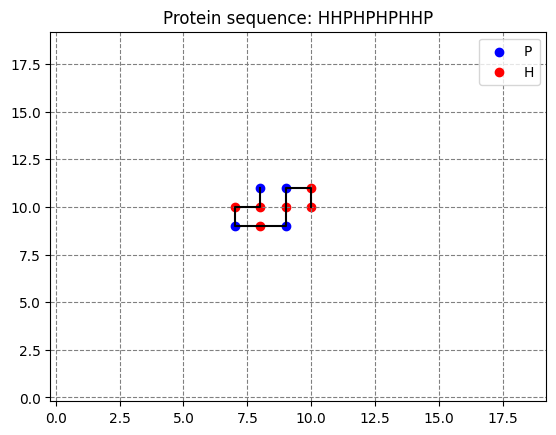

In [9]:
grid_size = 2*n - 1
x = ILP_graph_formulation(protein_binary_sequence, grid_size, additional_constr=False)
positions = grid_positions_from_optimal(x)
plot_folding(protein_binary_sequence, protein_sequence, positions, grid_size)

### Grid Size and Elimination of Variables

#### Method 1
It is possible to set a number of variables to zero by noting that the shortest path between any pair of vertices is either even or odd and if the distance between two amino acids in the sequence is even (odd) then their distance $ d_{ij}^{uv} $ in the grid must be even (odd).  

Moreover we can eliminate from the grid all the points with $ d_{nn}^{uv} \gt n $

#### Method 2 : reduce the grid
Another approach to reduce the number of variables and speed-up the convergence is to reduce the size of the grid by considering a grid of vertices $ (i,j) $ such that  
$ n-p \leq i \leq 2n-1 \qquad\text{and}\qquad n-p \leq j \leq n+p \qquad\text{where}\qquad p = \frac{n}{2} $


In this notebook we are going to implement the 2nd method.

Dim x: 1650
Dim y: 27225
Number of edges: 304
Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-18
Read LP format model from file /var/folders/57/yk3w62md44z9m6ndy61mkkz80000gn/T/tmpd4tfcknj.pyomo.lp
Reading time = 0.01 seconds
x28876: 2270 rows, 1955 columns, 14515 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 2270 rows, 1955 columns and 14515 nonzeros
Model fingerprint: 0x37257002
Variable types: 1 continuous, 1954 integer (1954 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 3.0000000
Presolve removed 1498 rows and 1430 columns
Presolve time: 0.08s
Presolved: 772 rows, 525 columns, 2849 nonzeros
Variable types: 0 continuous, 525 integer (525 b

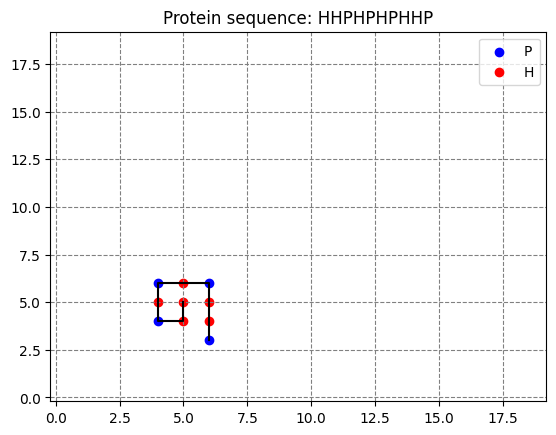

In [10]:
import networkx as nx

def ILP_graph_formulation_reduced_grid(binary_seq):
    model = ConcreteModel()

    ###################
    #   VARIABLES     #
    ###################

    n = len(binary_seq) # sequence length
    p = int(n/2)

    # Set of indices
    model.K = RangeSet(0, n - 1)    # set of indexes in sequence 
    model.K1 = RangeSet(0, n - 2)
    model.I = RangeSet(n - p, 2*n - 1) 
    model.J = RangeSet(n - p, n + p)
    model.H = Set(initialize=get_hydrophobic_set(binary_seq))   # set of indexes in sequence where value is 1 (hydrophobic)

    # Decision Variables
    model.x = Var(model.K, model.I, model.J, within=Binary)
    model.y = Var(model.I, model.J, model.I, model.J, within=Binary)
    print("Dim x:", len(model.x))
    print("Dim y:", len(model.y))

    G = nx.Graph()

    n = len(binary_seq)

    # add nodes
    for i in model.I:
        for j in model.J:
                G.add_node( (i, j) )

    # add edges
    for i, j in G.nodes():
         for u, v in G.nodes():
              if is_adjacent(i, j, u, v):
                   G.add_edge( (i, j), (u, v) )
    print("Number of edges:", G.number_of_edges())

    ###################
    #   CONSTRAINTS   #
    ###################

    model.constraints = ConstraintList()

    # the first amino acid is placed on the center of the grid (n,n)
    model.constraints.add(expr = ( model.x[0, n, n] == 1 ) )

    # each vertex has at most one amino acid
    for i in model.I:
        for j in model.J:
            model.constraints.add(expr = ( sum( model.x[k, i, j] for k in model.K ) <= 1 ) )
        
    # each amino acid is placed at exactly one vertex
    for k in model.K:
        model.constraints.add(expr = ( sum( model.x[k, i, j] for i in model.I for j in model.J ) == 1 ) )

    # if amino acid k is placed at (i, j) then amino acid k+1 is placed at a vertex (u, v) adjacent
    # to vertex (i, j)
    for k in model.K1:
        for i in model.I:
            for j in model.J:
                try:
                    model.constraints.add(expr = ( model.x[k, i, j] <= sum( model.x[k+1, u, v] for (u, v) in G[(i,j)] ) ) )
                except:
                    # if node is not in edges
                    pass
    

    # we want y[i, j ,u, v]=1 only if an H amino acid is placed at (i,j) and another amino acid H is placed at a neighboring vertex
    for ((i, j), (u, v)) in G.edges():
        model.constraints.add(expr = ( model.y[i, j, u, v] <= sum( model.x[k, i, j] for k in model.H ) ) )
        model.constraints.add(expr = ( model.y[i, j, u, v] <= sum( model.x[k, u, v] for k in model.H ) ) )


    ###################
    #   OBJECTIVE     #
    ###################
    model.obj = Objective(expr = ( sum( model.y[i, j, u, v] for ((i, j), (u, v)) in G.edges() ) ), sense = maximize)


    ###################
    #   SOLVER        #
    ###################
    sol = SolverFactory('gurobi').solve(model, tee=True)

    # CHECK SOLUTION STATUS

    # Get a JSON representation of the solution
    sol_json = sol.json_repn()

    if sol_json['Solver'][0]['Status'] == 'ok':
        print("Optimal solution value:", model.obj())
        print("\tValues of the decision variables:", ) 
    else:
        print('Error in solving the model')
    
    return [[[model.x[k, i, j]() for j in model.J] for i in model.I] for k in model.K]


grid_size = 2*n - 1
x = ILP_graph_formulation_reduced_grid(protein_binary_sequence)
positions = grid_positions_from_optimal(x)
plot_folding(protein_binary_sequence, protein_sequence, positions, grid_size)

### Alternative formulation
This alternative formulation differs from the original because instead of anchoring the first amino acid $ s_{1} $ to the center of the grid $ (n,n) $ we just require that it is placed somewhere with the constraint:
$$ \sum_{i} { \sum_{j} { x_{ij}^{k} } } = 1 $$
Moreover, in this case we only require a $ n*n $ grid. The disadvantage is that with this formulation we cannot eliminate variables like before. Hence, as we can see by running the following code, it is slower than the previous cases (ceteris paribus).

In [8]:
# No reduction of variables

grid_size = n
x = ILP_graph_formulation(protein_binary_sequence, grid_size, additional_constr=False, formulation="alternative")
positions = grid_positions_from_optimal(x)
plot_folding(protein_binary_sequence, protein_sequence, positions, grid_size)

Number of edges: 306
Dim x: 5832
Dim y: 104976
Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-18
Read LP format model from file /var/folders/57/yk3w62md44z9m6ndy61mkkz80000gn/T/tmp1hw8nrh2.pyomo.lp
Reading time = 0.01 seconds
x110809: 3862 rows, 6139 columns, 32320 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 3862 rows, 6139 columns and 32320 nonzeros
Model fingerprint: 0x753ce04d
Variable types: 1 continuous, 6138 integer (6138 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 1 rows and 1 columns
Presolve time: 0.03s
Presolved: 3861 rows, 6138 columns, 32319 nonzeros
Variable types: 0 continuous, 6138 integer (6138

Exception in thread Thread-6 (_mergedReader):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyomo/common/tee.py", line 506, in _mergedReader
    ready_handles = select(
OSError: [Errno 9] Bad file descriptor


KeyboardInterrupt: 

## Protein structure prediction using the 3D-HP side chain model
In this section we took inspiration and tried to reproduce the results from the paper [An integer programming model for protein structure prediction using the 3D-HP side chain model](https://www.sciencedirect.com/science/article/pii/S0166218X15003078). The 3D-HP model they considered assumes that each amino acid is represented by a backbone and a side chain. All elements (backbone or side chain) occupy only one position in a cubic lattice and the side chain is always positioned in the neighbourhood of its respective backbone. Also successive backbones are positioned in neighbourhood points to maintain the sequence. As in the previous 2-D model, we are considering amino acid side chains to be either hydrophobic (H) or hydrophilic (P) according to the HP model.  
The objective is to maximize the number of non-local hydrophobic side chain contacts in order to find the most stable folding configuration. 

### Mathematical formulation
- $ S $ : binary string with length n
- $ S_{i} = \{0,1\} $ : element of string which is 1 if the side chain associated with the backbone is H and 0 otherwise
- $ I = \{1, ..., n\} $ : set of indices of $ S $
- $ L = \{1, ..., m\} $ : set of indices of the cubic lattice vertices
- $ I_{e} $ : set of even indices in $ I \qquad I_{o} $ : set of odd indices in $ I \qquad I = I_{e} \cup I_{o} $
- $ H_{e} $ : set of indices of H side chains in even positions in $ I $
- $ H_{o} $ : set of indices of H side chains in odd positions in $ I $
- $ P_{e} $ : set of indices of P side chains in even positions in $ I $
- $ P_{o} $ : set of indices of H side chains in odd positions in $ I $
- $ I = H_{e} \cup H_{o} \cup P_{e} \cup P_{o} $
- $ L_{e} $ : set of even elements in $ L \qquad L_{o} $ : set of odd elements in $ L \qquad L = L_{e} \cup L_{o} $
- $ N(v) $ : set of adjacent vertices to v in the lattice
- The vertices of the lattice are enumerated so that the neighbourhood of an even vertex are all odd vertices and viceversa
- $ E $ : set of feasible edges $ (v,w) $ such that $ v \in L_{o} $ and $ w \in L_{e} $, $ w \in N(v) $
- $ F $ : set of feasible edges $ (v,w) $ such that $ v \in L_{e} $ and $ w \in L_{o} $, $ w \in N(v) $
- $ \varepsilon_{hh} $ : energy of interaction between two H side chains, we can set $ \varepsilon_{hh} = 1 $

In the paper you can find a full integer programming formulation that considers interactions between backbones, interactions between side chains (H or P) and interactions between backbones and side chains (H or P). But for the computational experiments they used a reduced model that considers only the interactions between H side chains, that are the most relevant ones for our purpose. So in this notebook we are going to discuss only the reduced model.


### Decision Variables
$$ x_{iv} =
\begin{cases}
      1 & \text{if backbone $ i $ is placed at lattice node $ v $}\\
      0 & \text{otherwise}
    \end{cases}   
$$
$$ y_{iv} =
\begin{cases}
      1 & \text{if side chain $ i $ is placed at lattice node $ v $}\\
      0 & \text{otherwise}
    \end{cases}   
$$
$$ hh_{(iv)(jw)} =
\begin{cases}
      1 & \text{if there's a contact between H side chain elements $ i $ and $ j $ on edge $ (v,w) $}\\
      0 & \text{otherwise}
    \end{cases}   
$$

### Objective function
$$ max ( \varepsilon_{hh} \sum_{(v,w) \in E} { \sum_{i \in H_{e}} { \sum_{j \in H_{o}} { hh_{(iv)(jw)} } } } ) $$

### Constraints
1. Odd backbone $ i $ is assigned to exactly one odd vertex $ v $ in the lattice
$$ \sum_{v \in L_{o}}{x_{iv}} = 1 \qquad \forall i \in I_{o} $$
2. Even backbone $ i $ is assigned to exactly one even vertex $ v $ in the lattice
$$ \sum_{v \in L_{e}}{x_{iv}} = 1 \qquad \forall i \in I_{e} $$
3. Odd side chain $ i $ is assigned to exactly one even vertex $ v $ in the lattice
$$ \sum_{v \in L_{e}}{x_{iv}} = 1 \qquad \forall i \in I_{o} $$
4. Even side chain $ i $ is assigned to exactly one odd vertex $ v $ in the lattice
$$ \sum_{v \in L_{o}}{x_{iv}} = 1 \qquad \forall i \in I_{e} $$
5. Each odd vertex in the lattice contains at most one odd backbone or one even side chain
$$ \sum_{i \in I_{o}}{x_{iv}} + \sum_{j \in I_{e}}{y_{jv}} \leq 1 \qquad \forall v \in L_{o} $$
6. Each even vertex in the lattice contains at most one even backbone or one odd side chain
$$ \sum_{i \in I_{e}}{x_{iv}} + \sum_{j \in I_{o}}{y_{jv}} \leq 1 \qquad \forall v \in L_{e} $$
7. 8 Consecutive backbone elements are placed at adjacent vertices in the lattice
$$ \sum_{w \in N(v)}{x_{(i+1)w}} \geq x_{iv} \qquad \forall i \in I_{o} - \{n\} \qquad \forall v \in L_{o} $$
$$ \sum_{w \in N(v)}{x_{(i+1)w}} \geq x_{iv} \qquad \forall i \in I_{e} - \{n\} \qquad \forall v \in L_{e} $$
9. 10 Each side chain is placed on a neighbourhood of its corresponding backbone
$$ \sum_{w \in N(v)}{y_{iw}} \geq x_{iv} \qquad \forall i \in I_{o} \qquad \forall v \in L_{o} $$
$$ \sum_{w \in N(v)}{y_{iw}} \geq x_{iv} \qquad \forall i \in I_{e} \qquad \forall v \in L_{e} $$
11. 12 If there's a contact between side chains $ i $ and $ j $ on edge $ (v,w) $ then the side chains must be placed on vertices $ v $ and $ w $
$$ \sum_{j \in H_{o}}{hh_{(iv)(jw)}} \leq y_{iv} \qquad \forall i \in H_{e} \qquad \forall (v,w) \in E $$
$$ \sum_{i \in H_{e}}{hh_{(iv)(jw)}} \leq y_{jw} \qquad \forall j \in H_{o} \qquad \forall (v,w) \in E $$
13. The decision variables are binary
$$ x_{iv}, y_{iv} \in \{0,1\} $$
$$ hh_{(iv)(jw)} \in \{0,1\} $$

In [11]:
def ILP_3D(binary_seq, l_size):
    model = ConcreteModel()

    ###################
    #   VARIABLES     #
    ###################

    n = len(binary_seq)
    m = l_size*l_size*l_size

    # Set of indices
    model.I = RangeSet(0, n-1)
    model.Ie = Set(initialize=get_even_indices(n))
    model.Io = Set(initialize=get_odd_indices(n))
    model.He = Set(initialize=get_HP_indices(binary_seq, polarity=1, parity=0))
    model.Ho = Set(initialize=get_HP_indices(binary_seq, polarity=1, parity=1))
    model.Pe = Set(initialize=get_HP_indices(binary_seq, polarity=0, parity=0))
    model.Po = Set(initialize=get_HP_indices(binary_seq, polarity=0, parity=1))
    model.L = RangeSet(0, m-1)
    model.Le = Set(initialize=get_even_indices(m))
    model.Lo = Set(initialize=get_odd_indices(m))
    model.E = Set(initialize=get_feasible_set(m, n, l_size))
    print("He:", get_HP_indices(binary_seq, polarity=1, parity=0))
    print("Ho:", get_HP_indices(binary_seq, polarity=1, parity=1))
    print("Pe:", get_HP_indices(binary_seq, polarity=0, parity=0))
    print("Po:", get_HP_indices(binary_seq, polarity=0, parity=1))
    print("Le:", get_even_indices(m))
    print("Lo:", get_odd_indices(m))

    # Decision Variables
    model.x = Var(model.I, model.L, within=Binary)
    model.y = Var(model.I, model.L, within=Binary)
    model.hh = Var(model.I, model.L, model.I, model.L, within=Binary)


    ###################
    #   CONSTRAINTS   #
    ###################

    model.constraints = ConstraintList()

    # ADDED CONSTRAINTS (not in the paper for some reason)
    # Each backbone must be placed on a vertex with the same parity, if the parity is not the same then x[i,v] must be 0
    for i in model.I:
        for v in model.L:
            model.constraints.add(expr = ( model.x[i,v] <= 1 - abs(i-v)%2 ))
    # Each side chain must be placed on a vertex with opposite parity, if the parity is the same then y[i,v] must be 0
    for i in model.I:
        for v in model.L:
            model.constraints.add(expr = ( model.y[i,v] <= abs(i-v)%2 ))

    # Each backbone is assigned to exactly one vertex v in the lattice with the same parity
    for i in model.Io:
        model.constraints.add(expr = ( sum( model.x[i,v] for v in model.Lo ) == 1 ) )
    for i in model.Ie:
        model.constraints.add(expr = ( sum( model.x[i,v] for v in model.Le ) == 1 ) )
    
    # Each side chain is assigned to exactly one vertex in the lattice with opposite parity
    for i in model.Io:
        model.constraints.add(expr = ( sum( model.y[i,v] for v in model.Le ) == 1 ) )
    for i in model.Ie:
        model.constraints.add(expr = ( sum( model.y[i,v] for v in model.Lo ) == 1 ) )

    # Each odd vertex in the lattice contains at most one odd backbone or one even side chain
    for v in model.Lo:
        model.constraints.add(expr = ( sum( model.x[i,v] for i in model.Io ) + sum( model.y[j,v] for j in model.Ie ) <= 1 ) )
    # Each even vertex in the lattice contains at most one even backbone or one odd side chain
    for v in model.Le:
        model.constraints.add(expr = ( sum( model.x[i,v] for i in model.Ie ) + sum( model.y[j,v] for j in model.Io ) <= 1 ) )

    # Consecutive backbone elements are placed at adjacent vertices in the lattice
    for i in model.Io:
        if i != (n-1):
            for v in model.Lo:
                model.constraints.add(expr = ( sum( model.x[i+1,w] for w in neighboring_set_3d(v, l_size) ) >= model.x[i,v] ) )
    for i in model.Ie:
        if i != (n-1):
            for v in model.Le:
                model.constraints.add(expr = ( sum( model.x[i+1,w] for w in neighboring_set_3d(v, l_size) ) >= model.x[i,v] ) )

    # Each side chain is placed on a neighbourhood of its corresponding backbone
    for i in model.Io:
        for v in model.Lo:
            model.constraints.add(expr = ( sum( model.y[i,w] for w in neighboring_set_3d(v, l_size) ) >= model.x[i,v] ) )
    for i in model.Ie:
        for v in model.Le:
            model.constraints.add(expr = ( sum( model.y[i,w] for w in neighboring_set_3d(v, l_size) ) >= model.x[i,v] ) )

    # If there's a contact between side chains i and j on edge (v,w) then the side chains must be placed on vertices v and w
    for (v,w) in model.E:
        for i in model.He:
            model.constraints.add(expr = ( sum( model.hh[i,v,j,w] for j in model.Ho ) <= model.y[i,v] ) )
        for j in model.Ho:
            model.constraints.add(expr = ( sum( model.hh[i,v,j,w] for i in model.He ) <= model.y[j,w] ) )


    ###################
    #   OBJECTIVE     #
    ###################
    model.obj = Objective(expr = ( sum( model.hh[i,v,j,w] for (v,w) in model.E for i in model.He for j in model.Ho ) ), sense = maximize)


    ###################
    #   SOLVER        #
    ###################
    sol = SolverFactory('gurobi').solve(model, tee=True)

    # CHECK SOLUTION STATUS

    # Get a JSON representation of the solution
    sol_json = sol.json_repn()

    if sol_json['Solver'][0]['Status'] == 'ok':
        print("Optimal solution value:", model.obj())
        print("\tValues of the decision variables:", ) 
    else:
        print('Error in solving the model')
    
    return ([[model.x[i,v]() for v in model.L] for i in model.I], [[model.y[i,v]() for v in model.L] for i in model.I])


protein_sequence = "HPPPPHHHHPPHPHPHHHPHPPHHPPH" #"HPPHHPHPH"
protein_binary_sequence = get_binary_string(protein_sequence)
n = len(protein_sequence)
l_size = 5

X, Y = ILP_3D(protein_binary_sequence, l_size)
    

He: [0, 6, 8, 16, 22, 26]
Ho: [5, 7, 11, 13, 15, 17, 19, 23]
Pe: [2, 4, 10, 12, 14, 18, 20, 24]
Po: [1, 3, 9, 21, 25]
Le: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124]
Lo: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99, 101, 103, 105, 107, 109, 111, 113, 115, 117, 119, 121, 123]
Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-18
Read LP format model from file /var/folders/57/yk3w62md44z9m6ndy61mkkz80000gn/T/tmpahep8mwz.pyomo.lp
Reading time = 0.11 seconds
x11397376: 18643 rows, 35551 columns, 98714 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M1 P

[ 38  37  32  31  26  51  52  77  78  53  54  59  64  89  94  93  92  67
  66  41  40  35  60  85 110 105 106]
[[3 2 1]
 [2 2 1]
 [2 1 1]
 [1 1 1]
 [1 0 1]
 [1 0 2]
 [2 0 2]
 [2 0 3]
 [3 0 3]
 [3 0 2]
 [4 0 2]
 [4 1 2]
 [4 2 2]
 [4 2 3]
 [4 3 3]
 [3 3 3]
 [2 3 3]
 [2 3 2]
 [1 3 2]
 [1 3 1]
 [0 3 1]
 [0 2 1]
 [0 2 2]
 [0 2 3]
 [0 2 4]
 [0 1 4]
 [1 1 4]]
[ 63  12   7   6  27  56  57  82  83  28  29  58  39  88  69  68  87  62
  65  36  15  10  61  86 111  80  81]
[[3 2 2]
 [2 2 0]
 [2 1 0]
 [1 1 0]
 [2 0 1]
 [1 1 2]
 [2 1 2]
 [2 1 3]
 [3 1 3]
 [3 0 1]
 [4 0 1]
 [3 1 2]
 [4 2 1]
 [3 2 3]
 [4 3 2]
 [3 3 2]
 [2 2 3]
 [2 2 2]
 [0 3 2]
 [1 2 1]
 [0 3 0]
 [0 2 0]
 [1 2 2]
 [1 2 3]
 [1 2 4]
 [0 1 3]
 [1 1 3]]


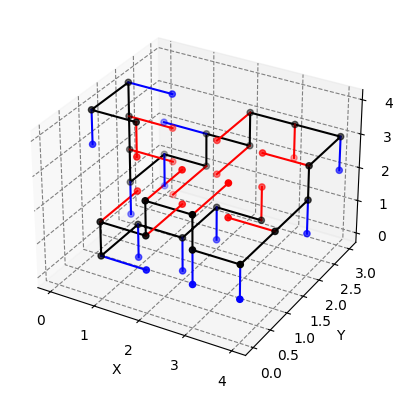

In [12]:
bb_x, bb_y, bb_z, bb_positions, bb_pos = lattice_positions_from_optimal(X, l_size=l_size)
print(bb_pos)
print(bb_positions)

sc_x, sc_y, sc_z, sc_positions, sc_pos = lattice_positions_from_optimal(Y, l_size=l_size)
print(sc_pos)
print(sc_positions)

H_set = get_hydrophobic_set(protein_binary_sequence)
P_set = list(set(np.arange(0,n)) - set(H_set))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(bb_x, bb_y, bb_z, 'black') # line segments
ax.scatter(bb_x, bb_y, bb_z, c='black', marker='o')
ax.scatter(sc_x[H_set], sc_y[H_set], sc_z[H_set], c='red', marker='o')
ax.scatter(sc_x[P_set], sc_y[P_set], sc_z[P_set], c='blue', marker='o')

for v in H_set:
    ax.plot([bb_x[v], sc_x[v]], [bb_y[v], sc_y[v]], [bb_z[v], sc_z[v]], 'red') # line segments
for v in P_set:
    ax.plot([bb_x[v], sc_x[v]], [bb_y[v], sc_y[v]], [bb_z[v], sc_z[v]], 'blue') # line segments

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()